# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s). 

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf 
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf 


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



## Network implementation

*   Element seznama
*   Element seznama



In [ ]:
import torch.nn as nn
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample
        
    def forward(self, x):
        skip_connection = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.downsample != None:
            skip_connection = self.downsample(skip_connection)
        x = self.relu(x + skip_connection)
        return x


class ResNet18FCN(nn.Module):
    
    def __init__(self):
        num_classes = 13
        super(ResNet18FCN, self).__init__()
        # First layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # CNN Block 1
        self.block1_0 = Block(64, 64, downsample= None, stride = 1)
        self.block1_1 = Block(64, 64, stride=1)
        
        # Cnn Block 2
        self.block2_0 = Block(64, 128, downsample= self._downsample(64, 128), stride = 2)
        self.block2_1 = Block(128, 128, stride=1)
        
        # Cnn Block 3
        self.block3_0 = Block(128, 256, downsample= self._downsample(128, 256), stride = 2)
        self.block3_1 = Block(256, 256, stride=1)
        # Cnn Block 2
        self.block4_0 = Block(256, 512, downsample= self._downsample(256, 512), stride = 2)
        self.block4_1 = Block(512, 512, stride=1)
        
        self.upsample = nn.ConvTranspose2d(512, num_classes, 32, 32)

        
    def forward(self, x):
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        # CNN Block 1
        x = self.block1_0(x)
        x = self.block1_1(x)
        
        # CNN Block 2
        x = self.block2_0(x)
        x = self.block2_1(x)
        
        # CNN Block 3
        x = self.block3_0(x)
        x = self.block3_1(x)
        # CNN Block 4
        x = self.block4_0(x)
        x = self.block4_1(x)
        x = self.upsample(x)
        return x 
    
    def _downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0),
             nn.BatchNorm2d(out_channels)
        )


In [ ]:
import torch.nn as nn
from torchvision.transforms import CenterCrop
# Inspired by https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
class u_net_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(u_net_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv1(x)))
        x = self.relu(self.batchnorm(self.conv2(x)))
        return x


class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = u_net_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        skip_conn = self.conv(x)
        out = self.pool(skip_conn)
        return out, skip_conn


class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = u_net_block(out_channels + out_channels, out_channels)   

    def forward(self, x, skip_conn):
        x = self.up(x)
        x = torch.cat([x, skip_conn], axis=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf
        num_classes = 13
        self.enc_block1 = encoder_block(3, 64)
        self.enc_block2 = encoder_block(64, 128)
        self.enc_block3 = encoder_block(128, 256)
        self.enc_block4 = encoder_block(256, 512)
        self.enc_block5 = u_net_block(512, 1024)

        self.dec_block1 = decoder_block(1024, 512)
        self.dec_block2 = decoder_block(512, 256)
        self.dec_block3 = decoder_block(256, 128)
        self.dec_block4 = decoder_block(128, 64)
        self.out = nn.Conv2d(64, 13, kernel_size = 1, padding = 0)

        
    def forward(self, x):
        # Implement the forward pass+)
        x, skip1 = self.enc_block1(x)
        x, skip2 = self.enc_block2(x)
        x, skip3 = self.enc_block3(x)
        x, skip4 = self.enc_block4(x)
        x = self.enc_block5(x)
        x = self.dec_block1(x, skip4)
        x = self.dec_block2(x, skip3)
        x = self.dec_block3(x, skip2)
        x = self.dec_block4(x, skip1)
        x = self.out(x)
        return x

##Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge 


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
!rm -r data
!mkdir data
!unzip -q seg_data.zip -d ./data/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM
From (redirected): https://drive.google.com/uc?id=1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM&confirm=t&uuid=7f74ee60-5db2-4986-bfbd-8205118bb212
To: /content/seg_data.zip
100% 2.74G/2.74G [01:05<00:00, 41.6MB/s]
rm: cannot remove 'data': No such file or directory


In [ ]:
from google.colab import drive
# Due to too many downloads we need to get the data from MyDrive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/Faks/FRI/Magisterij\ 1/DL/seg_data.zip -d ./data

Mounted at /content/gdrive/


## Data loader

In [ ]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./data/seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

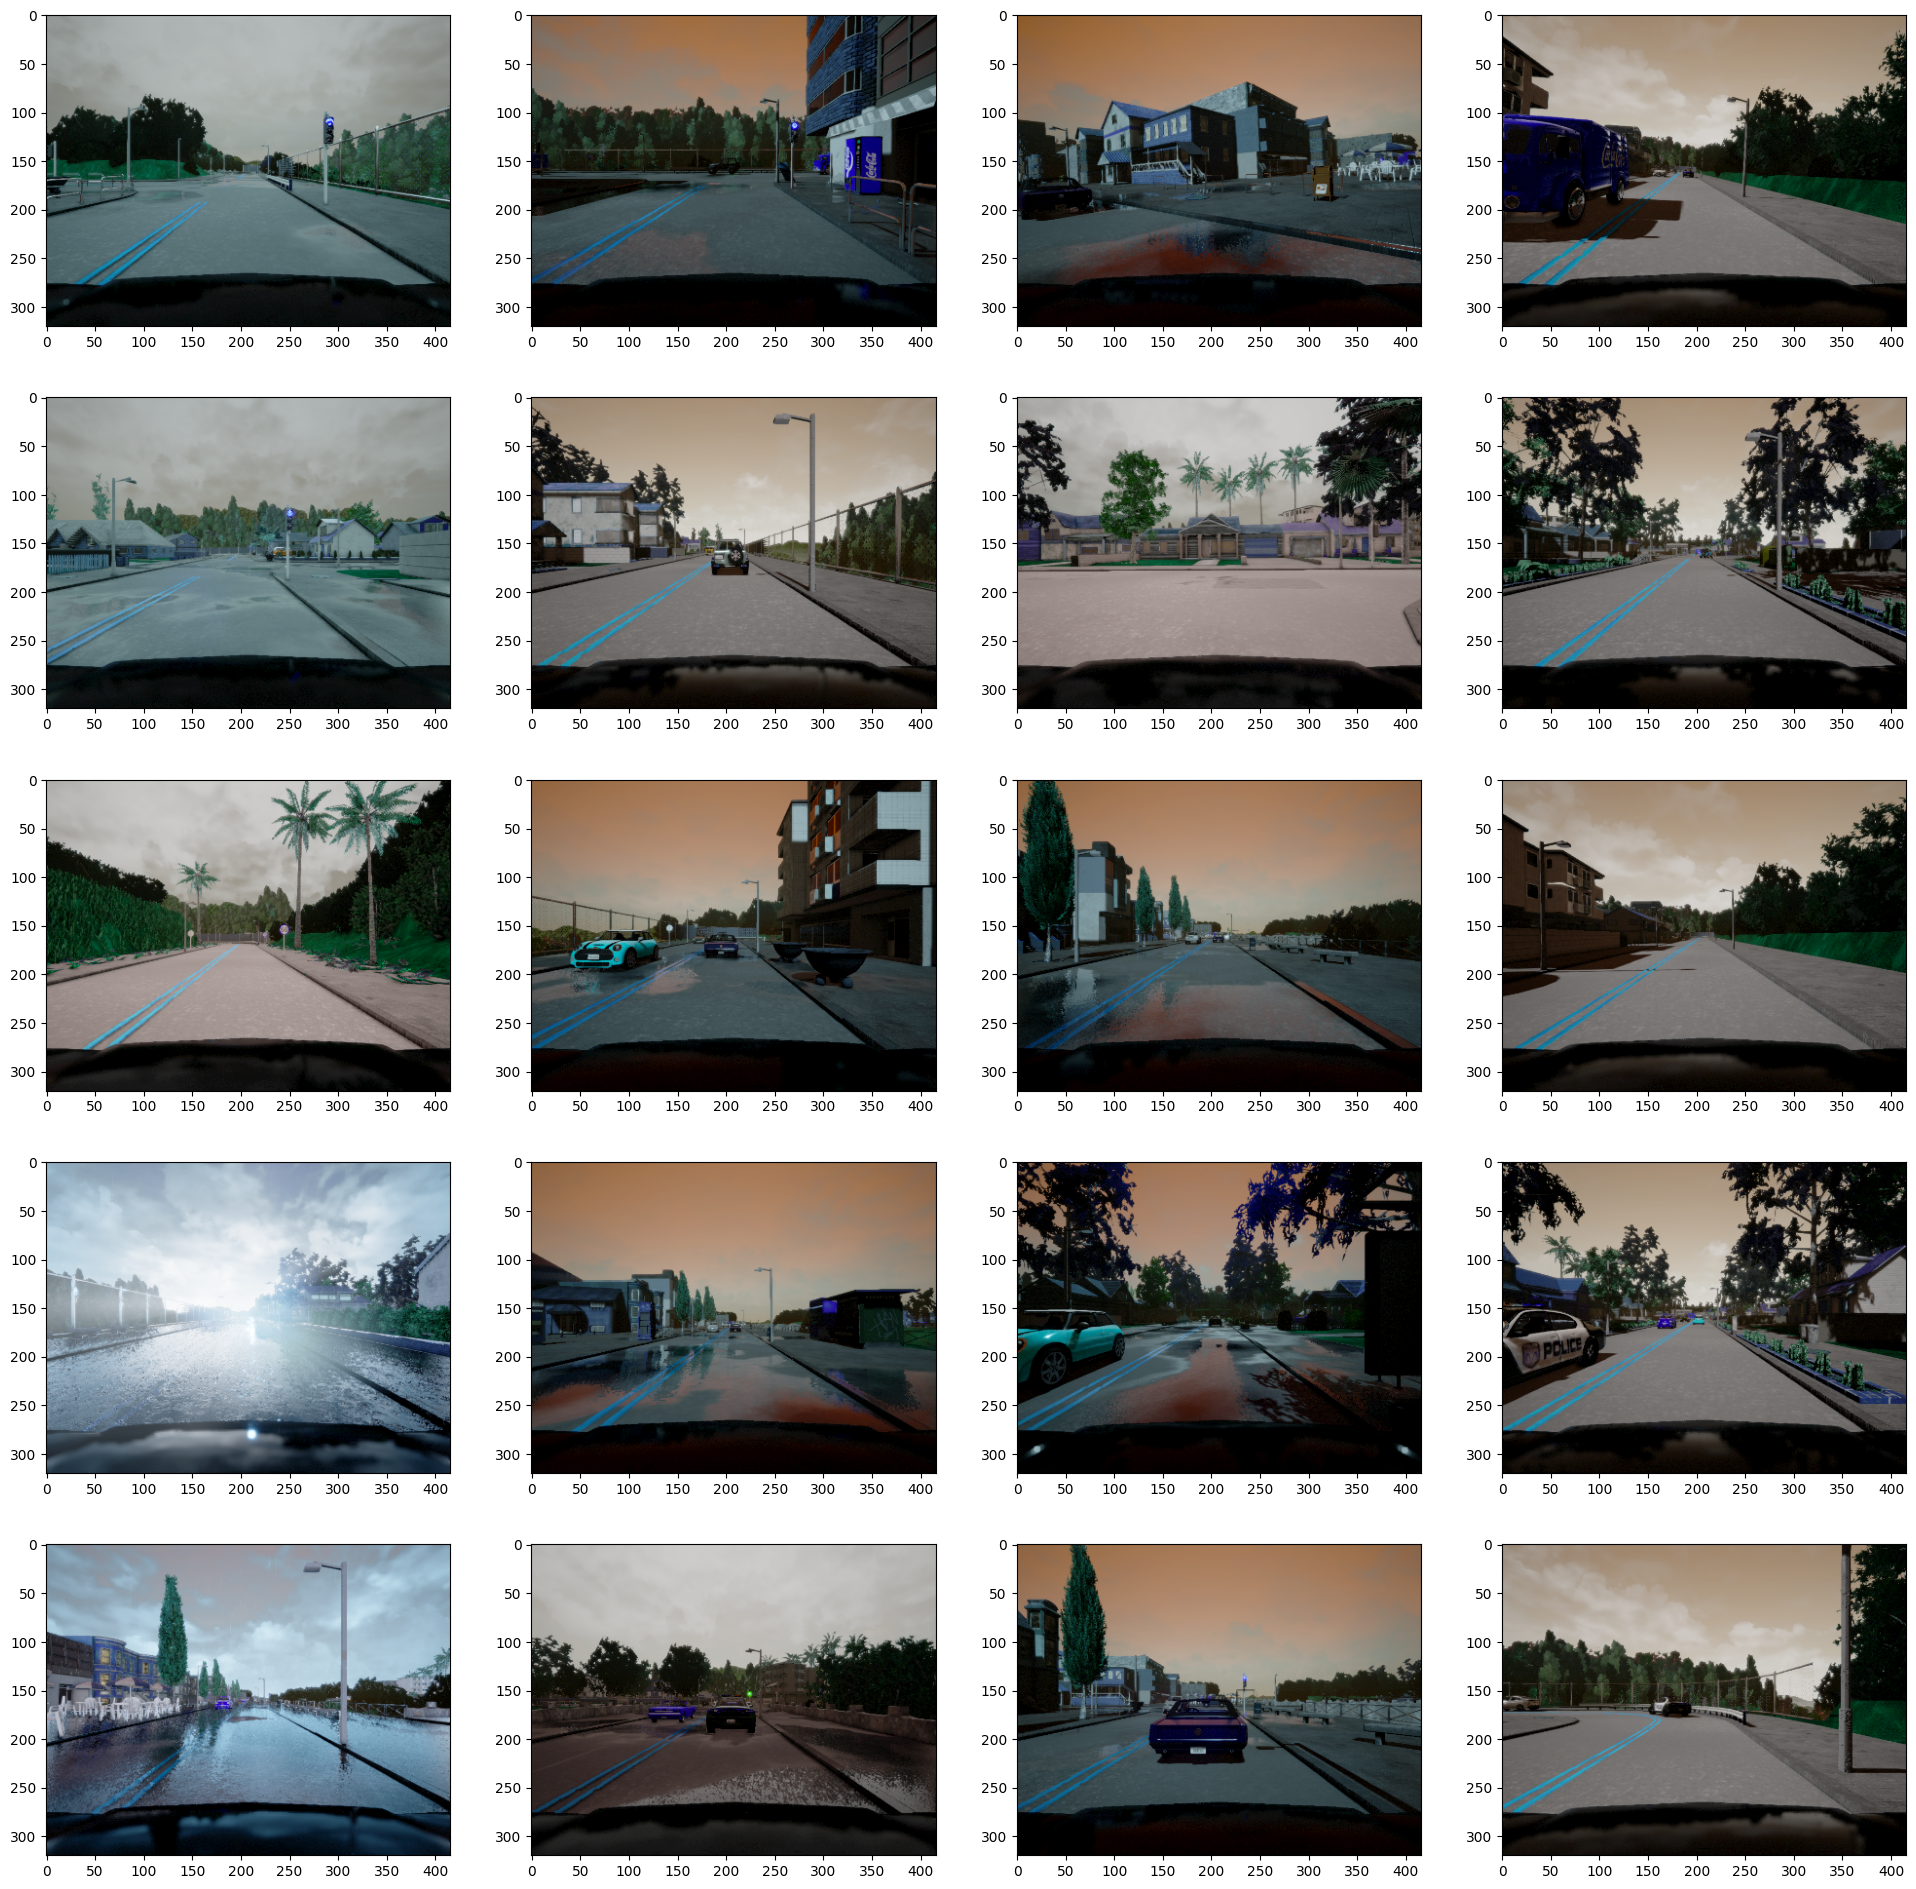

In [ ]:
import torch
from tqdm.notebook import tqdm

trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()



In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

net = ResNet18FCN()
net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
schedular = StepLR(optimizer, 2, 0.1)
epochs=5
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          #print(outputs.shape)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)

0/5:   0%|          | 0/4000 [00:00<?, ?img/s]

KeyboardInterrupt: ignored

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


u_net = UNet()
u_net.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(u_net.parameters(), lr=0.0001)
epochs=4
for epoch in range(epochs):  # loop over the dataset multiple times
    with tqdm(total=len(trainset), desc =str(epoch)+"/"+str(epochs), miniters=int(50),unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs = data["image"]
          labels = data["mask"]
          inputs = inputs.cuda()
          labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = u_net(inputs)
          #print(outputs.shape)
          loss = criterion(outputs, labels[:,0,:,:].long())
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': np.round(loss.data.cpu().detach().numpy(),5)})
          prog_bar.update(4)
    schedular.step()

0/4:   0%|          | 0/4000 [00:00<?, ?img/s]

KeyboardInterrupt: ignored

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation 



In [ ]:
 from sklearn.metrics import confusion_matrix, jaccard_score
 import numpy as np

# Implementation from stackoverflow
def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    classes = range(14)
    current = confusion_matrix(y_true, y_pred, labels=classes)
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / (union.astype(np.float32) + 0.00000001)
    return np.mean(IoU)

# Implementation with jaccard score
def jaccard(y_pred, y_true, average='macro'):
  labels = range(14)
  jaccards = []

  for label in labels:
      jaccard = jaccard_score(y_true.flatten(),y_pred.flatten(), average=average)
      jaccards.append(jaccard)
  return np.mean(jaccards)


# Actual calculation of IoU
mean_IoU = []
jaccard_micro = []
jaccard_macro = []

for i in range(len(testset)):
  batch = testset[i]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  
  outputs = net(img_tensor)
  outputs = torch.argmax(outputs, axis=1)
  out_image = outputs.detach().cpu().numpy()
  jaccard_micro.append(jaccard(out_image, labels, 'micro'))
  jaccard_macro.append(jaccard(out_image, labels, 'macro'))
  IoU = compute_iou(out_image, labels)
  mean_IoU.append(IoU)
mean_IoU = np.mean(mean_IoU)
mean_jaccard_micro = np.mean(jaccard_micro)
mean_jaccard_macro = np.mean(jaccard_macro)
print(f'Resnet mean IoU = {mean_IoU}', f'\nResnet jaccard micro IoU = {mean_jaccard_micro}',f'\nResnet jaccard micro IoU = {mean_jaccard_macro}'+ '\n-------------------')



mean_IoU = []
jaccard_micro = []
jaccard_macro = []
for i in range(len(testset)):
  batch = testset[i]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  
  outputs = u_net(img_tensor)
  outputs = torch.argmax(outputs, axis=1)
  out_image = outputs.detach().cpu().numpy()
  jaccard_micro.append(jaccard(out_image, labels, 'micro'))
  jaccard_macro.append(jaccard(out_image, labels, 'macro'))
  IoU = compute_iou(out_image, labels)
  IoU = compute_iou(out_image, labels)
  mean_IoU.append(IoU)

# Print the results
mean_jaccard_micro = np.mean(jaccard_micro)
mean_jaccard_macro = np.mean(jaccard_macro)
mean_IoU = np.mean(mean_IoU)
print(f'Unet mean IoU = {mean_IoU}', f'\nUnet jaccard micro IoU = {mean_jaccard_micro}',f'\nUnet jaccard macro IoU = {mean_jaccard_macro}')



Resnet mean IoU = 0.4936474890054263 
Resnet jaccard micro IoU = 0.8780281968036489 
Resnet jaccard micro IoU = 0.5450317893986806
-------------------


## Visualize the results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

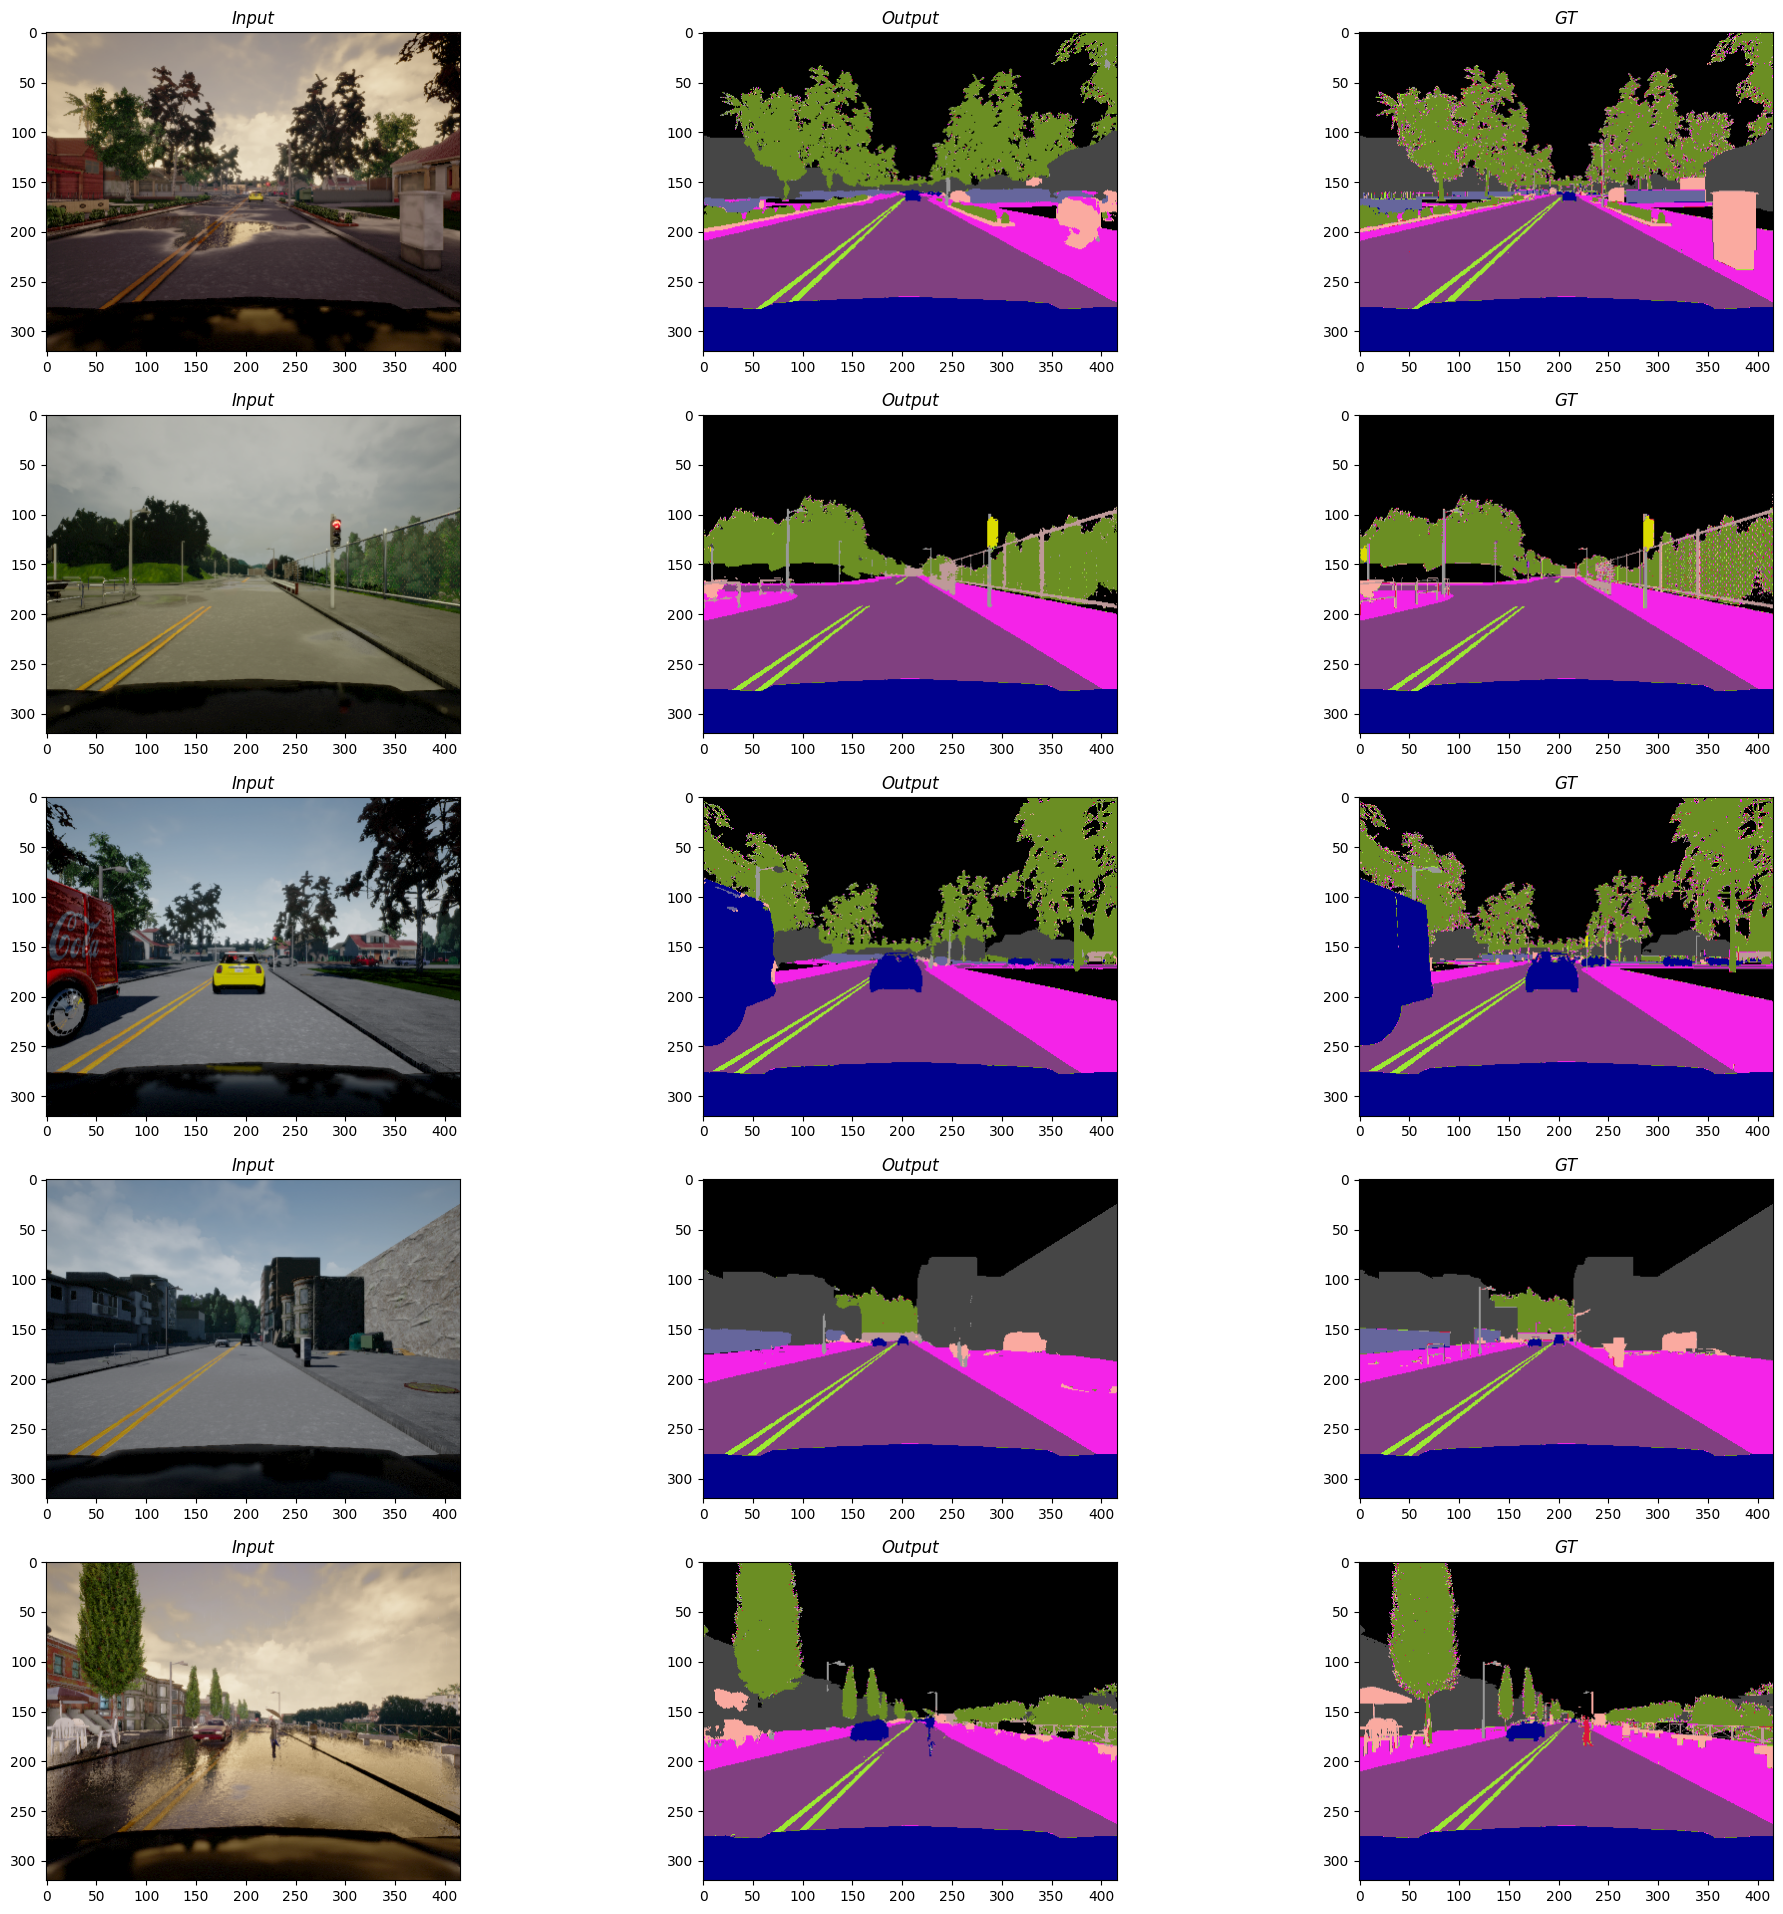

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
label_colors = np.array([
[0,0,0], # unlabeled
[70,70,70], # building
[190,153,153], # fence
[250,170,160], # other
[220,20,60], # pedestrian
[153,153,153], # pole
[157,234,50], # road line
[128,64,128], # road
[244,35,232], # sidewalk
[107,142,35], # vegetation
[0,0,142], # car
[102,102,156], # wall
[220,220,0], # traffic sign
])


net.eval()


fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[np.random.randint(len(testset))]
  img = batch['image']
  labels = batch['mask']
  img_tensor = torch.from_numpy(img).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = u_net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy()
  seg_mask = np.argmax(out_image,axis=0)
  seg_mask_color = label_colors[seg_mask]
  gt_mask_color = label_colors[labels[0,:,:]]

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  labels = labels[0,:,:]
  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(img)
  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("Output", fontstyle='italic')
  plt.imshow(seg_mask_color)
  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(gt_mask_color)

plt.savefig("unet3.png")
files.download("unet3.png") 

plt.show()